In [32]:
# 导入所需的库
import random
import re
import jieba
import pymysql
import toad
from toad.plot import bin_plot

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_curve, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_precision_recall_curve
from xgboost import XGBClassifier

from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS

from terminaltables import AsciiTable

## 1. 数据预处理

### 1.1 数据获取及清洗
数据来源自 https://www.itjuzi.com/person 的创业者人物页面，经由爬虫采集入本地mysql数据库

In [2]:
with pymysql.connect("localhost","root","K4JxZPZpgKfVwgjPY*pnyMgu","crawler" ) as cursor:
    cursor.execute('''
                select id, city, com_claim, com_history, com_round, com_scope, combo_make_com, des, education, 
                    famous_com, famous_school, follow_num, follow_status, invse_history, invse_round, invse_scope, 
                    invst_claim, invst_history, job, location, logo, name, prov, type, created_at, updated_at 
                from itjuzi_entrepreneur
                ''')
    desc = cursor.description
    columns = [col[0] for col in desc]
    entrepreneurs = pd.DataFrame(cursor.fetchall(), columns=columns)

In [3]:
entrepreneurs.set_index('id', inplace=True)
entrepreneurs.head(1)

,city,com_claim,com_history,com_round,com_scope,combo_make_com,des,education,famous_com,famous_school,...,invst_claim,invst_history,job,location,logo,name,prov,type,created_at,updated_at
id,,,,,,,,,,,,,,,,,,,,,
79,西安,0,"[{'id': 57, 'name': '见见', 'position': '创始人及CEO...","[{'name': 'A轮'}, {'name': '尚未获投'}]",[{'name': '社交网络'}],1,见见联合创始人及CEO，西安八千里网络科技有限公司法人代表。曾创办过原点世界、爱物团等。,"[{'id': 51, 'name': '威尔士大学'}]",0,0,...,0,[],[],in,https://cdn.itjuzi.com/assets/front/images/img...,任文勇,陕西,[{'name': '创业者'}],2021-04-02 22:04:24,2021-04-02 22:04:24


In [4]:
(entrepreneurs.invse_history.value_counts()/len(entrepreneurs))[:5]

[]                                    0.997307
[{'id': 61424, 'name': '魔力伞'}]        0.000071
[{'id': 10317248, 'name': '送礼神器'}]    0.000071
[{'id': 30357983, 'name': '贝仙特'}]     0.000035
[{'id': 54931, 'name': '秒啊时交所'}]      0.000035
Name: invse_history, dtype: float64

In [5]:
# 将列表类型的字符串都转化为列表的长度，人为构建新的特征：工作经历数，任职公司数，教育经历数，投资数，被投数
entrepreneurs['job_num'] = entrepreneurs.job.apply(lambda x:len(eval(x)))
entrepreneurs['com_num'] = entrepreneurs.com_history.apply(lambda x:len(eval(x)))
entrepreneurs['education_num'] = entrepreneurs.education.apply(lambda x:len(eval(x)))
entrepreneurs['invse_num'] = entrepreneurs.invse_history.apply(lambda x:len(eval(x)))
entrepreneurs['invst_num'] = entrepreneurs.invst_history.apply(lambda x:len(eval(x)))

In [6]:
# 选定目标变量，这里用是否ipo作为目标变量来衡量是否为潜力创业者
def is_ipo(x):
    x_list = eval(x)
    ipo_num = 0
    for item in x_list:
        if item['name'] == '已上市':
           ipo_num = ipo_num +1 
    if ipo_num > 0:
        return 1
    else:
        return 0
    return ipo_num

entrepreneurs['is_ipo']= entrepreneurs.com_round.apply(is_ipo)

In [7]:
entrepreneurs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28220 entries, 79 to 159400
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   city            28074 non-null  object        
 1   com_claim       28220 non-null  int64         
 2   com_history     28220 non-null  object        
 3   com_round       28220 non-null  object        
 4   com_scope       28220 non-null  object        
 5   combo_make_com  28220 non-null  int64         
 6   des             28220 non-null  object        
 7   education       28220 non-null  object        
 8   famous_com      28220 non-null  int64         
 9   famous_school   28220 non-null  int64         
 10  follow_num      28220 non-null  int64         
 11  follow_status   28220 non-null  int64         
 12  invse_history   28220 non-null  object        
 13  invse_round     28220 non-null  object        
 14  invse_scope     28220 non-null  object        
 15  

### 1.2 数据探索性分析

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/33/vvlybwtd6t38vhyw4ky_qm8w0000gn/T/jieba.cache
Loading model cost 0.704 seconds.
Prefix dict has been built successfully.


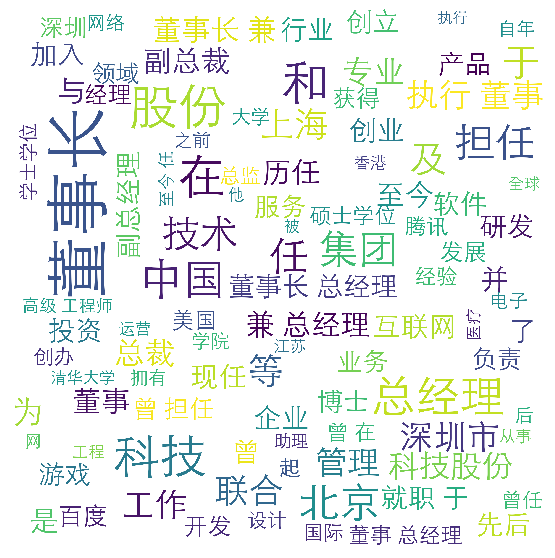

In [9]:
# 词云分析
word = '。'.join(entrepreneurs[entrepreneurs.is_ipo==True].des.values)

# 图片模板和字体
image=np.array(Image.open('bg.jpeg')) 
font=r'STHeiti Light.ttc' 
  
# 去掉英文，保留中文 
resultword=re.sub("[A-Za-z0-9\[\`\~\!\@\#\$\^\&\*\(\)\=\|\{\}\'\:\;\'\,\[\]\.\<\>\/\?\~\。\@\#\\\&\*\%]", "",word) 
wordlist_after_jieba = jieba.cut(resultword) 
wl_space_split = " ".join(wordlist_after_jieba) 
  
# 设置停用词 
sw = set(STOPWORDS) 
sotp_word = set(["创始人", "有限公司", "股份有限公司", "公司", "毕业", "年", "月", "的", "至"])
sw = set.union(sw, sotp_word)

# 进行词云建模
my_wordcloud = WordCloud(scale=8,font_path=font,mask=image,stopwords=sw,background_color='white',
                         max_words = 100,max_font_size = 60,random_state=20).generate(wl_space_split) 
  
#显示生成的词云 
plt.figure(figsize=(10,10))
plt.imshow(my_wordcloud)
plt.axis("off") 
plt.show() 

有ipo经历的创业者简介中，科技行业比较突出，并且集中在一线城市(北京、上海、深圳)，并且大厂经历较多(腾讯、百度)，在历任公司中大多都处于高管层级

In [26]:
# 本次分析中暂时不对文本类变量进行分析
data = entrepreneurs[['com_claim', 'combo_make_com', 'famous_com', 'famous_school', 'follow_num', 
                      'follow_status', 'invst_claim', 'job_num', 'com_num', 'education_num', 'invse_num',
                     'invst_num', 'is_ipo']]

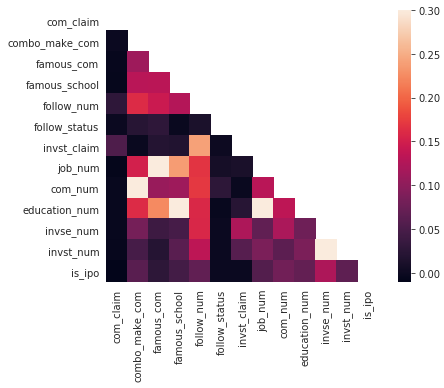

In [11]:
# 对剩余变量做相关性热力图分析
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

实际上选择的变量和目标变量没有很强的相关性

### 1.3 数据集划分

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 打乱数据
data = shuffle(data)
train, test = train_test_split(data,test_size = 0.2, random_state=42)

### 1.4 异常值检测

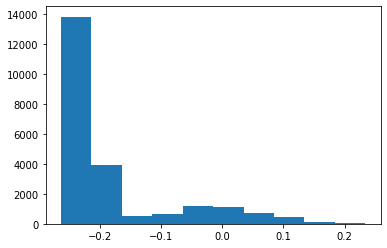

In [14]:
from pyod.models.iforest import IForest
detector = IForest(
                n_estimators=100,
                max_samples="auto",
                contamination=0.1,
                max_features=1.,
                bootstrap=False,
                n_jobs=1,
                random_state=None,
                verbose=0,
                behaviour='old'
            )

X=train[['com_claim', 'combo_make_com', 'famous_com', 'famous_school', 'follow_num', 
                      'follow_status', 'invst_claim', 'job_num', 'com_num', 'education_num', 'invse_num',
                     'invst_num']]
detector.fit(X)

y_pred_score = detector.decision_scores_
threshold = np.percentile(y_pred_score, 99) # 选定异常值得分的阈值
train = train.iloc[np.argwhere(y_pred_score <= threshold)[:,0]]

plt.hist(y_pred_score)
plt.show()

### 1.5 不平衡数据处理
由于正负样本比例过大 1:64，采取过采样建模会产生严重过拟合，因此采用算法来处理，例如逻辑回归和随机森林的 class_weight

In [15]:
# from imblearn.over_sampling import BorderlineSMOTE 
# sampler = BorderlineSMOTE(k_neighbors=5, )

# X = train.drop(['is_ipo'], axis=1)
# y = train['is_ipo']
# columns = X.columns.tolist()

# X_resampled, y_resampled = sampler.fit_resample(
#     X.values,
#     y.values
# #     np.asarray(y.values.astype(np.int32))
# )

# train = pd.DataFrame(
#                 np.column_stack([X_resampled, y_resampled]),
#                 columns=columns + ['is_ipo']
#             )

### 1.6 特征筛选

In [16]:
# iv值及相关性筛选
train, dropped_1 = toad.selection.select(
            train,
            target='is_ipo',
            empty=0.5,
            iv=0.02,
            corr=0.7,
            return_drop=True,
            exclude=[]
        )

# 方差膨胀因子筛选
train, dropped_2 = toad.selection.drop_vif(
            train,
            threshold=10,
            return_drop=True,
            exclude=[]
        )

# 逐步迭代筛选
train, dropped_3 = toad.selection.stepwise(
            train,
            target='is_ipo',
            exclude=[],
            direction='both',
            criterion='aic',
            estimator='ols',
            intercept=False,
            return_drop=True
        )

test = test[train.columns]

## 2 数据建模

### 2.1 模型训练

In [18]:
# Logistic回归模型
logistic_regression = {
    'model': LogisticRegression(class_weight='balanced'),
    'param': {
        "max_iter":[100,1000,10000,20000],
        'random_state':[1234]
    }
}

# XGBoost模型
xgb = {
    'model': XGBClassifier(),
    'param': {
        'max_depth':[3,5,7,9,11,13],
        'min_child_weight':[0,2,5,10,20],
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'n_estimators':[100],
        'seed':[1234]
    }
}

# SVM模型
svm = {
    'model': SVC(),
    'param': None
}

# 决策树
decision_tree = {
    'model': DecisionTreeClassifier(),
    'param': {
        'max_depth': range(1, 10),
        'criterion': ['entropy', 'gini']
    }
}

# 随机森林
random_forest = {
    'model': RandomForestClassifier(class_weight={1:65}),
    'param': None
}

# AdaBoost
ada_boost = {
    'model': AdaBoostClassifier(),
    'param': {"n_estimators": range(150, 300, 50)}
}

# 朴素贝叶斯
naive_bayes = {
    'model': GaussianNB(),
    'param': None
}

# 所有模型映射字典
classifiers_dict = {
    'Logistic Regression': logistic_regression,
    'XGB': xgb,
    'Decision Tree': decision_tree,
    'Random Forest': random_forest,
    'AdaBoost': ada_boost,
    'Naive Bayes': naive_bayes
}

In [19]:

class ModelTraining:
    """模型训练"""

    def select_model(self, model_method):
        if model_method in classifiers_dict.keys():
            model_dict = classifiers_dict[model_method]
            return model_dict['model']     
        else:
            raise ValueError("暂不支持所选择的模型，请重新选择！")

    def fit_train(self, model_method, X, y):
        model = self.select_model(model_method)
        model.fit(X, y)
        return model
    

### 2.2 模型评估

In [20]:



class ModelEvaluation:
    """模型评估"""
    def __init__(
            self,
            target_names=None,
            target_column=None
    ):
        self.target_names = target_names
        self.target_column = target_column

    @staticmethod
    def show_table(data, title, inner_row_border=False):
        """
        将数据以格式化的表格在命令行输出
        :param data: 需要打印的数据. [list]
        :param title: 表格的标题. [str]
        :param inner_row_border: 是否显示行边框. [Boolean]
        :return:
        """
        table = AsciiTable(data, title=title)
        table.inner_row_border = inner_row_border
        print(table.table)

    @staticmethod
    def compute_pred_label(pred_prob, threshold):
        """
        给定分割阈值，将预测的概率转化为预测标签
        :param pred_prob: 预测概率. [list]
        :param threshold: 分割阈值. [float]
        :return:
        """
        pred_label = []
        for i in pred_prob:
            if i >= threshold:
                pred_label.append(1)
            else:
                pred_label.append(0)
        return pred_label




    def classification_report(self, target_label, target_true, target_names):
        report = classification_report(target_true, target_label, target_names=target_names)
        return report

    def _confusion_matrix(self, y_true, y_pred, labels):
        """
        计算单个数据集的混淆矩阵
        :param y_true: 真实标签列表. [list]
        :param y_pred: 预测概率列表. [list]
        :param labels: 预测标签名称. [list]
        :return:
        """
        matrix = confusion_matrix(y_true, y_pred)

        data = []
        data.append([""] + labels)
        for i in range(matrix.shape[0]):
            data.append([labels[i]] + matrix[i, :].tolist())
        return data

    def confusion_matrix(
            self,
            train_target_label,
            train_target_true,
            test_target_label,
            test_target_true,
            labels,
    ):
        """
        计算训练集、验证集和测试集的混淆矩阵
        :param train_target_label: 训练集预测标签. [list]
        :param train_target_true: 训练集真实标签. [list]
        :param test_target_label: 测试集预测标签. [list]
        :param test_target_true: 测试集真实标签. [list]
        :param labels: 预测标签名称列表,e.g:['未付费','付费']. [list]
        :return:
        """
        train_matrix = self._confusion_matrix(train_target_true, train_target_label, labels)
        test_matrix = self._confusion_matrix(test_target_true, test_target_label, labels)

        self.show_table(train_matrix, "confusion_matrix(train)", inner_row_border=True)
        self.show_table(test_matrix, "confusion_matrix(test)", inner_row_border=True)

    def roc_curve(self, model, X, y):
        """
        绘制ROC曲线
        :param model: 所选择的模型
        :param X: 自变量
        :param y: 因变量
        :return:
        """
        plot_roc_curve(model, X, y)
        plt.show()
        
    def pr_curve(self, model, X, y):
        plot_precision_recall_curve(model, X, y)
        plt.show()


    def _single_metric(self, y_true, y_pred, y_score):
        """
        计算单个数据集的各个单指标评估，准确率、召回率、精确率、F1值、AUC
        :param y_true: 真实标签列表. [list]
        :param y_pred: 预测标签列表. [list]
        :param y_score: 预测标签概率. [list]
        :return:
        """
        # 计算准确率
        acc = accuracy_score(y_true, y_pred)

        # 计算召回率
        recall = recall_score(y_true, y_pred)

        # 计算精确率
        precision = precision_score(y_true, y_pred)

        # 计算f1值
        f1 = f1_score(y_true, y_pred)

        # 计算auc值
        auc_score = roc_auc_score(y_true, y_score)

        return [acc, recall, precision, f1, auc_score]

    def single_metric_report(
            self,
            train_target_label,
            train_target_true,
            train_target_prob,
            test_target_label,
            test_target_true,
            test_target_prob,
    ):
        """
        计算各个数据集的单指标评估，准确率、召回率、精确率、F1值、AUC
        :param train_target_label: 训练集预测标签. [list]
        :param train_target_true: 训练集真实标签. [list]
        :param train_target_prob: 训练集预测概率. [list]
        :param test_target_label: 测试集预测标签. [list]
        :param test_target_true: 测试集真实标签. [list]
        :param test_target_prob: 测试集预测概率. [list]
        :return:
        """
        train_metric = self._single_metric(train_target_true, train_target_label, train_target_prob)
        test_metric = self._single_metric(test_target_true, test_target_label, test_target_prob)

        data = []
        data.append(["data", "accuracy", "recall", "precision", "f1", "auc"])
        data.append(["train"] + train_metric)
        data.append(["test"] + test_metric)
        self.show_table(data, title="single_metric")

    def optimal_threshold(self, y_true, y_prob):
        """
        确定最优的分割阈值
        :param y_true: 验证集真实标签.[list]
        :param y_prob: 验证集预测概率.[list]
        :return:
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        self.show_table([["optimal_threshold"], [optimal_threshold]], title="optimal_threshold")
        return optimal_threshold

    def fit_evaluate(self, model, data, model_method):
        """
        对模型和数据计算常用的模型评估指标
        :param model: 所选择的模型
        :param data: 数据集，一个字典，包含train、test两个数据集. [dict]
        :return:
        """
        print('-----------------------------{0}-----------------------------'.format(model_method))
        exclude = [self.target_column]
        print(exclude)
        train_target_prob = model.predict_proba(data["train"].drop(exclude, axis=1))[:, 1]
        test_target_prob = model.predict_proba(data["test"].drop(exclude, axis=1))[:, 1]

        # 确定最佳分隔阈值
        threshold = self.optimal_threshold(data['test'][self.target_column], test_target_prob)

        # 计算预测标签
        train_target_label = self.compute_pred_label(train_target_prob, threshold)
        test_target_label = self.compute_pred_label(test_target_prob, threshold)


        # 计算准确率，召回率，精确率，F1值，AUC
        self.single_metric_report(
            train_target_label,
            data["train"][self.target_column],
            train_target_prob,
            test_target_label,
            data["test"][self.target_column],
            test_target_prob
        )

        # 计算混淆矩阵
        self.confusion_matrix(
            train_target_label,
            data["train"][self.target_column],
            test_target_label,
            data["test"][self.target_column],
            self.target_names
        )

        # 绘制ROC曲线

        self.roc_curve(model, data["train"].drop(exclude, axis=1), data["train"][self.target_column])
        self.roc_curve(model, data["test"].drop(exclude, axis=1), data["test"][self.target_column])
        
        # 绘制PR曲线
        self.pr_curve(model, data["train"].drop(exclude, axis=1), data["train"][self.target_column])
        self.pr_curve(model, data["test"].drop(exclude, axis=1), data["test"][self.target_column])
        


In [21]:
def main(data, model_method):
    X = train.drop(['is_ipo'], axis=1)
    y = train['is_ipo']
    trainer = ModelTraining()
    model = trainer.fit_train(model_method, X, y)

    model_evaluation = ModelEvaluation(
                target_column='is_ipo',
                target_names=["一般创业者", "潜力创业者"]
            )
    model_evaluation.fit_evaluate(model, data, model_method)

In [ ]:
# classifiers_dict = {
#     'Logistic Regression': logistic_regression,
#     'XGB': xgb,
#     'Decision Tree': decision_tree,
#     'AdaBoost': ada_boost,
#     'Naive Bayes': naive_bayes
# }

-----------------------------Random Forest-----------------------------
['is_ipo']
+optimal_threshold----+
| optimal_threshold   |
+---------------------+
| 0.49487615590134965 |
+---------------------+
+single_metric---------------+--------------------+---------------------+----------------------+--------------------+
| data  | accuracy           | recall             | precision           | f1                   | auc                |
+-------+--------------------+--------------------+---------------------+----------------------+--------------------+
| train | 0.8201583680042948 | 0.4171779141104294 | 0.03429147755925366 | 0.06337371854613234  | 0.6551569030868698 |
| test  | 0.8198086463501063 | 0.336734693877551  | 0.03350253807106599 | 0.060941828254847646 | 0.5319121337680401 |
+-------+--------------------+--------------------+---------------------+----------------------+--------------------+
+confusion_matrix(train)--+------------+
|            | 一般创业者 | 潜力创业者 |
+------------+---

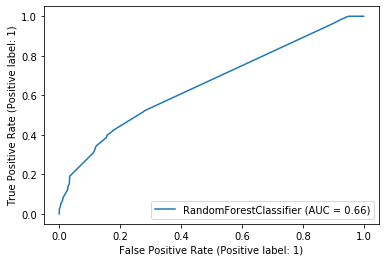

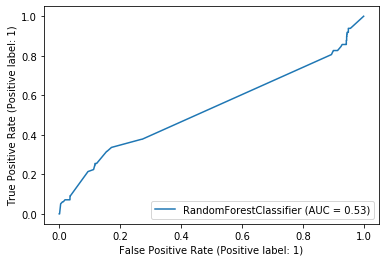

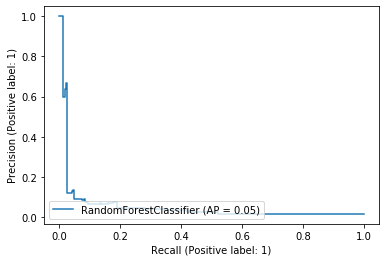

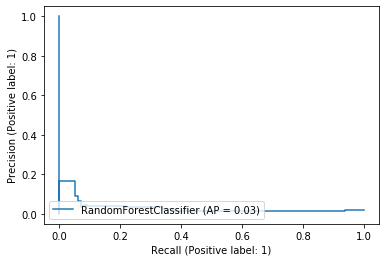

In [23]:
data_dict = {'train':train, 'test':test}
main(data_dict, 'Random Forest')

-----------------------------Logistic Regression-----------------------------
['is_ipo']
+optimal_threshold--+
| optimal_threshold |
+-------------------+
| 0.538313159170447 |
+-------------------+
+single_metric---------------+--------------------+----------------------+---------------------+--------------------+
| data  | accuracy           | recall             | precision            | f1                  | auc                |
+-------+--------------------+--------------------+----------------------+---------------------+--------------------+
| train | 0.7695163960094842 | 0.4325153374233129 | 0.02760375880971026  | 0.05189547294810453 | 0.6219869312647808 |
| test  | 0.7639971651311127 | 0.5102040816326531 | 0.037481259370314844 | 0.06983240223463687 | 0.6420779454948224 |
+-------+--------------------+--------------------+----------------------+---------------------+--------------------+
+confusion_matrix(train)--+------------+
|            | 一般创业者 | 潜力创业者 |
+------------+-------

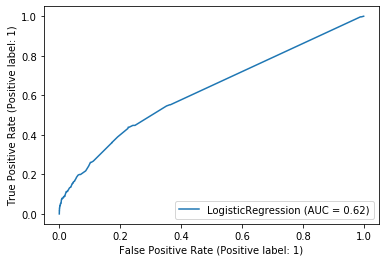

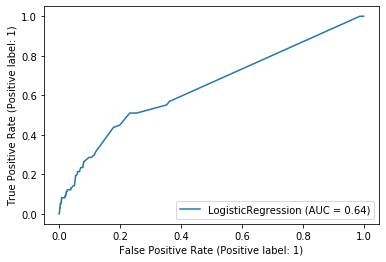

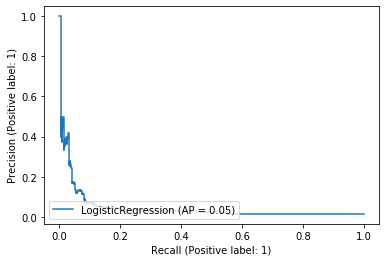

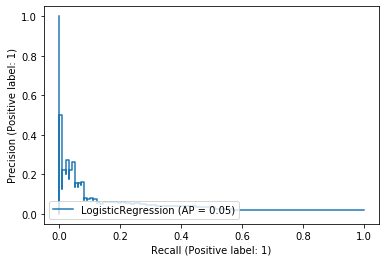

In [22]:
main(data_dict, 'Logistic Regression')

可以看到逻辑回归的泛化性较好，但是无论是训练集还是测试集其预测效果都不是很好

## 3. 变量分析

In [28]:
combiner = toad.transform.Combiner()
            
combiner.fit(
    data,
    y='is_ipo',
    method='chi',
    min_samples=0.05
)

In [29]:
bin_rule = combiner.export()

{'com_claim': [],
 'combo_make_com': [1],
 'famous_com': [],
 'famous_school': [],
 'follow_num': [],
 'follow_status': [],
 'invst_claim': [],
 'job_num': [1],
 'com_num': [2],
 'education_num': [1],
 'invse_num': [],
 'invst_num': []}

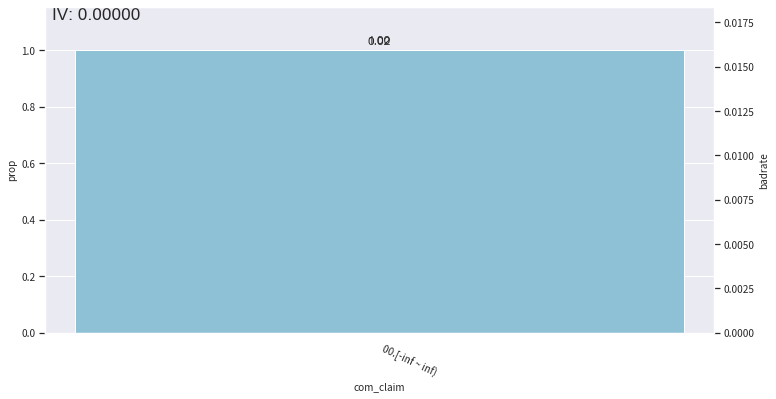

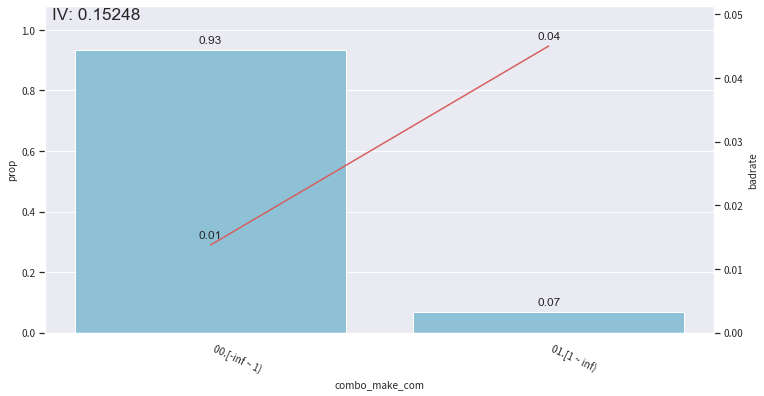

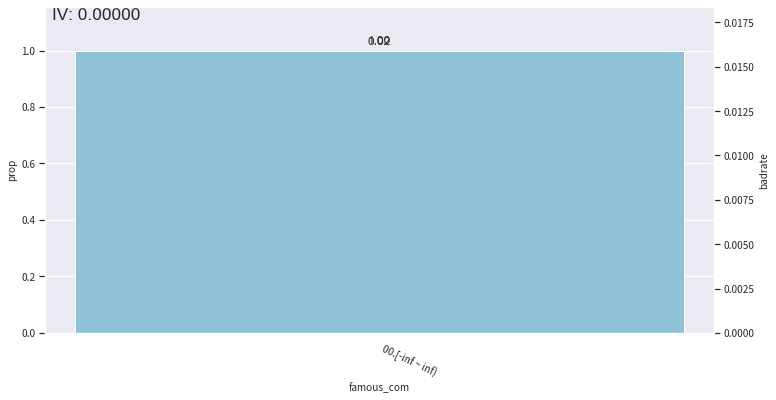

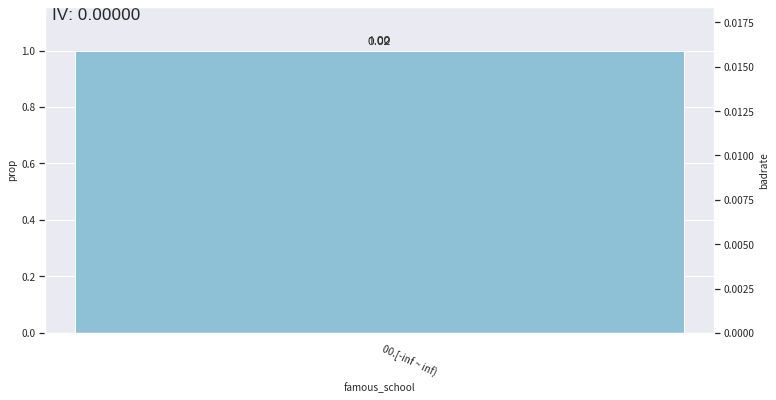

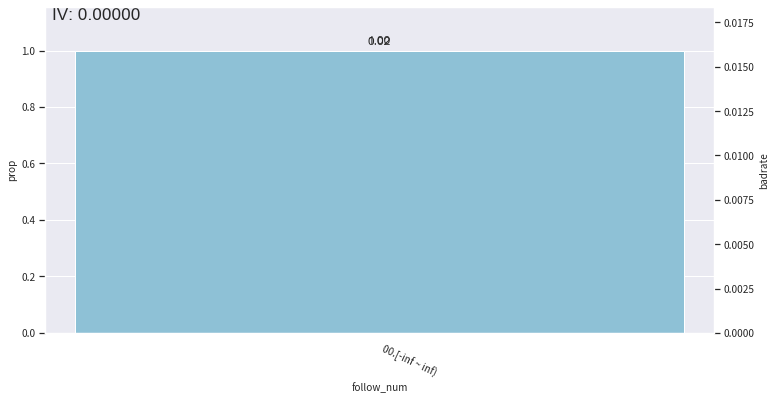

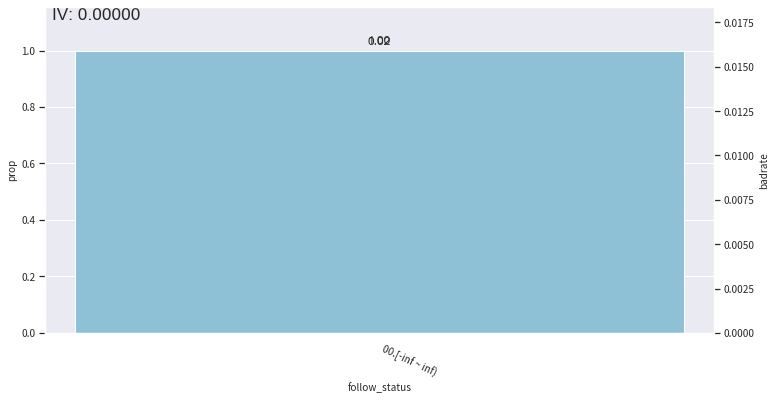

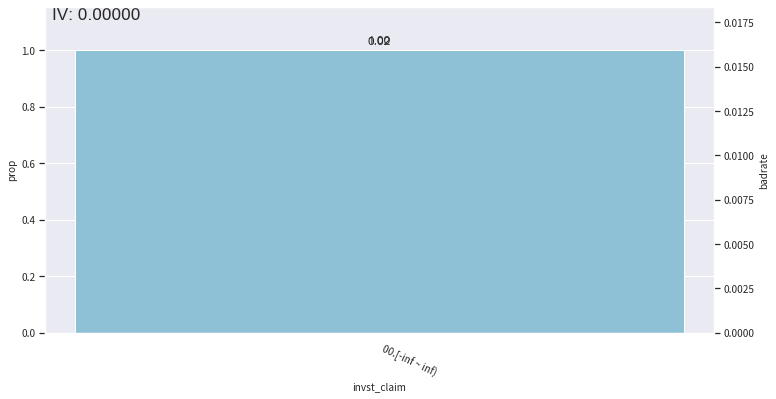

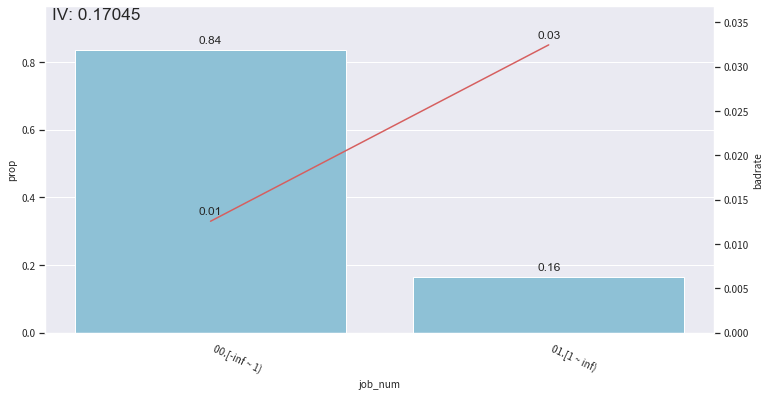

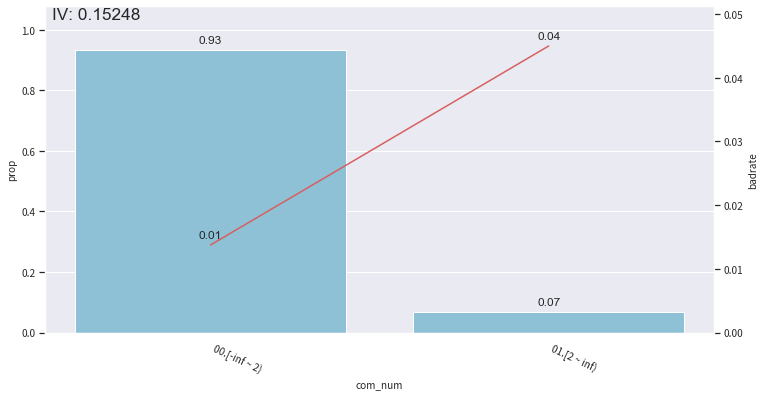

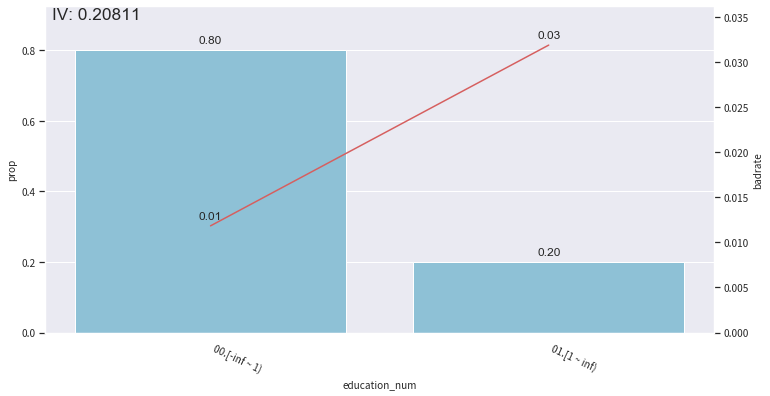

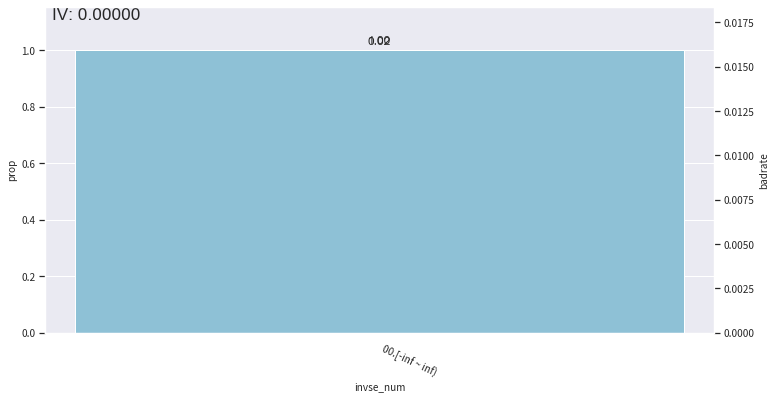

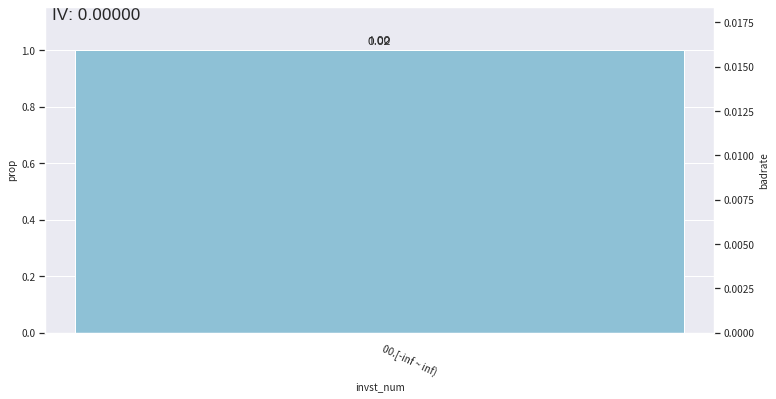

In [34]:
for col in data.columns:
    if col not in ['is_ipo']:
        bin_image = bin_plot(
            combiner.transform(data[[col, 'is_ipo']], labels=True),
            x=col,
            target='is_ipo'
        )

In [35]:
data.is_ipo.value_counts()/len(data)

0    0.98416
1    0.01584
Name: is_ipo, dtype: float64

潜力创业者的整体比例为 0.01584
可以看到单变量分析中以下几个特征比较重要
- combo_make_com: 连续创业公司数，当连续创业次数大于等于1时，潜力创业者的比例上升至 0.04。可以重点关注有连续创业行为的创业者
- job_num: 任职数，当任职数大于等于1时，潜力创业者的比例上升至 0.03
- com_num: 任职公司数，当任职公司数大于等于2时，潜力创业者的比例上升至 0.04，一般来说任职公司越多对商业运作模式理解更深刻，可以重点关注此类创业者
- education_num: 教育经历数，当教育经历数大于等于1时，潜力创业者的比例上升至 0.03

## 4. 反思
此次的 case 存在以下几个问题：
1. 样本量的问题，由于数据采集速度较慢，只采集了3万左右的数据进行分析
2. 选取的特征维度都是基于IT桔子信息的创业者人物库信息的数值型变量，特征较为单一
3. 时间分配问题，由于工作日现任工作较忙，抽不出过多精力在此项目上，还花费了一半的时间在调试、优化爬虫程序上。导致在数据建模和特征工作上的工作不太够。

基于以上的问题反思，此case有以下进一步的优化空间：
1. 继续优化爬虫，使其具有分布式(尚在开发)和稳定代理ip池子(已完成)的功能，提高数据采集的效率
2. 加入其他数据源的信息，例如招聘网站、网络搜索指数等。并且对文本数据进行自然语言处理分析，对社交网络和商业网络进行网络分析